In [1]:
!nvidia-smi

Fri Jan  7 11:12:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
# imports
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data
from torch import nn
import os
import matplotlib.pyplot as plt
import math
import torch.optim as optim
import skimage.transform as st
from torchvision import transforms
from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
!pip install -q labml_nn
from labml_nn.gan.wasserstein import DiscriminatorLoss, GeneratorLoss
from labml_nn.gan.stylegan import GradientPenalty
from torchvision import transforms
from PIL import Image

# FOR MAC
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# CONFIG CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device))
if str(device) == 'cuda':
  print(torch.cuda.get_device_name())

#import files from google drive and kaggle datasets api
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download jessicali9530/celeba-dataset
! unzip -qq /content/celeba-dataset.zip
! cp /content/drive/MyDrive/V_celeba_200k.pth /content/V_celeba_200k.pth
!cp /content/drive/MyDrive/gen_29.pth /content/gen_29.pth
!cp /content/drive/MyDrive/des_29.pth /content/des_29.pth

device: cuda
Tesla V100-SXM2-16GB


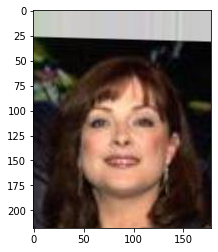

In [2]:
# test image
from PIL import Image
folder_path = '/content/img_align_celeba/img_align_celeba'
image_paths = os.listdir(folder_path)
image = Image.open(folder_path+'/'+image_paths[0])
data = np.asarray(image)
plt.imshow(data)

In [3]:
# dataloading funcs
trans_128 = transforms.Compose([
transforms.Resize((128,128)),
transforms.PILToTensor(),
transforms.ConvertImageDtype(torch.float),
 ])

trans_64 = transforms.Compose([
transforms.Resize((64,64)),
transforms.PILToTensor(),
transforms.ConvertImageDtype(torch.float),
 ])

class Dataset(torch.utils.data.Dataset):
  def __init__(self, image_path_names, transformation):
        self.image_path_names = image_path_names
        self.transformation =transformation
  def __len__(self):
        return len(self.image_path_names)
  def __getitem__(self, index):
        image_path = self.image_path_names[index]
        X = Image.open('/content/img_align_celeba/img_align_celeba'+'/'+image_path)
        X = self.transformation(X)
        X = X.swapaxes(1,2)
        return X
def get_loader(image_path_names, transformation, b_size):
  dataset = Dataset(image_path_names, transformation)
  loader = torch.utils.data.DataLoader(dataset, batch_size=b_size,
                                        shuffle=True, drop_last=True,
                                        pin_memory=True)
  return loader

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [15]:
# creatte V for PCA
pca_batch_size = 1000
n_v = 512

loader = get_loader(image_paths, trans_64, pca_batch_size)
for batch in loader:
  print(batch.shape)
  break

tensor_images = batch.reshape((pca_batch_size,-1)).to(device)
mean = tensor_images.mean(1).unsqueeze(1)
tensor_images_centered = tensor_images - mean
U, S, V = torch.pca_lowrank(tensor_images_centered, q=n_v, niter=3)
latent = torch.matmul(tensor_images_centered[:30,:], V[:, :n_v])


# recunstracting using inverse PCA
n = 27
data_original = torch.matmul(latent, V[:, :n_v].T) + mean[:30]
data_original = data_original.reshape((30,-1,64,64))
plt.imshow(batch[n,:,:,:].numpy().swapaxes(0,2))
plt.figure()
plt.imshow(data_original[n,:,:,:].cpu().detach().numpy().swapaxes(0,2))

# saving V
torch.save(V,'V_celeba_200k.pth')
!cp /content/V_celeba_200k.pth /content/drive/MyDrive/V_celeba_200k.pth

In [4]:
# model functions

class ToRGB(nn.Module):
    def __init__(self, d_latent: int, features: int):
        super().__init__()
        self.to_style = EqualizedLinear(d_latent, features, bias=1.0)
        self.conv = EqualizedConv2d(features, 3, kernel_size=1)
        self.bias = nn.Parameter(torch.zeros(3))
        self.activation = nn.LeakyReLU(0.2, True)
    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        return self.activation(x + self.bias[None, :, None, None])
class MiniBatchStdDev(nn.Module):
    def __init__(self, group_size: int = 4):
        super().__init__()
        self.group_size = group_size
    def forward(self, x: torch.Tensor):
        assert x.shape[0] % self.group_size == 0
        grouped = x.view(self.group_size, -1)
        std = torch.sqrt(grouped.var(dim=0) + 1e-8)
        std = std.mean().view(1, 1, 1, 1)
        b, _, h, w = x.shape
        std = std.expand(b, -1, h, w)
        return torch.cat([x, std], dim=1)
class DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        self.smooth = Smooth()
    def forward(self, x: torch.Tensor):
        x = self.smooth(x)
        return F.interpolate(x, (x.shape[2] // 2, x.shape[3] // 2), mode='bilinear', align_corners=False)
class UpSample(nn.Module):
    def __init__(self):
        super().__init__()
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.smooth = Smooth()
    def forward(self, x: torch.Tensor):
        return self.smooth(self.up_sample(x))
class Smooth(nn.Module):
    def __init__(self):
        super().__init__()
        kernel = [[1, 2, 1],
                  [2, 4, 2],
                  [1, 2, 1]]
        kernel = torch.tensor([[kernel]], dtype=torch.float)
        kernel /= kernel.sum()
        self.kernel = nn.Parameter(kernel, requires_grad=False)
        self.pad = nn.ReplicationPad2d(1)
    def forward(self, x: torch.Tensor):
        b, c, h, w = x.shape
        x = x.view(-1, 1, h, w)
        x = self.pad(x)
        x = F.conv2d(x, self.kernel)
        return x.view(b, c, h, w)
class EqualizedLinear(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: float = 0.):
        super().__init__()
        self.weight = EqualizedWeight([out_features, in_features])
        self.bias = nn.Parameter(torch.ones(out_features) * bias)
    def forward(self, x: torch.Tensor):
        return F.linear(x, self.weight(), bias=self.bias)
class EqualizedConv2d(nn.Module):
    def __init__(self, in_features: int, out_features: int,
                 kernel_size: int, padding: int = 0):
        super().__init__()
        self.padding = padding
        self.weight = EqualizedWeight([out_features, in_features, kernel_size, kernel_size])
        self.bias = nn.Parameter(torch.ones(out_features))
    def forward(self, x: torch.Tensor):
        return F.conv2d(x, self.weight(), bias=self.bias, padding=self.padding)
class EqualizedWeight(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.c = 1 / math.sqrt(np.prod(shape[1:]))
        self.weight = nn.Parameter(torch.randn(shape))
    def forward(self):
        return self.weight * self.c
class upsampling_block(nn.Module):
  def __init__(self, layers_in, layers_out, norm=True):
    super(upsampling_block, self).__init__()
    self.norm = norm
    self.upsample = UpSample()
    self.conv1 = EqualizedConv2d(layers_in, layers_out, kernel_size=3, padding=1)
    self.conv2 = EqualizedConv2d(layers_out, layers_out, kernel_size=3, padding=1)
    self.act = torch.nn.SiLU()
    if self.norm:
      self.bn1 = nn.BatchNorm2d(layers_out)
      self.bn2 = nn.BatchNorm2d(layers_out)
    self.scale_noise1 = nn.Parameter(torch.zeros(1))
    self.scale_noise2 = nn.Parameter(torch.zeros(1))
    self.to_rgb = ToRGB(layers_out,layers_out)
  def forward(self, x): 
    b, c, h, w = x.shape
    x = self.upsample(x)
    x = self.conv1(x)
    noise = torch.randn((b,c,1,1)).float().to(device)
    x = x + self.scale_noise1[None, :, None, None] * noise
    if self.norm:
      x = self.bn1(x)
    x = self.act(x)
    x = self.conv2(x)
    noise = torch.randn((b,c,1,1)).float().to(device)
    x = x + self.scale_noise2[None, :, None, None] * noise
    if self.norm:
      x = self.bn2(x)
    x = self.act(x)
    rgb = self.to_rgb(x)
    return x, rgb
class downsampling_block(nn.Module):
  def __init__(self, layers_in, layers_out, norm=True):
    super(downsampling_block, self).__init__()
    self.norm = norm
    self.residual = nn.Sequential(DownSample(),
                              EqualizedConv2d(layers_in, layers_out, kernel_size=1))
    self.downsample = DownSample()
    self.conv1 = EqualizedConv2d(layers_in, layers_out, kernel_size=3, padding=1)
    self.conv2 = EqualizedConv2d(layers_out, layers_out, kernel_size=3, padding=1)
    self.act = torch.nn.SiLU()
    self.scale = 1 / math.sqrt(2)
    if self.norm:
      self.norm1 = nn.InstanceNorm2d(layers_out, affine=True)
      self.norm2 = nn.InstanceNorm2d(layers_out, affine=True)
  def forward(self, x):
    residual = self.residual(x)
    x = self.conv1(x)
    if self.norm:
      x = self.norm1(x)
    x = self.act(x)
    x = self.conv2(x)
    if self.norm:
      x = self.norm2(x)
    x = self.act(x)
    x = self.downsample(x)
    return (x + residual) * self.scale
class generator(nn.Module):
  def __init__(self, d_hidden):
    super(generator, self).__init__()
    upsample_blocks_1 = [upsampling_block(d_hidden,d_hidden, norm=False) for i in range(3)]
    upsample_blocks_2 = [upsampling_block(d_hidden,d_hidden) for i in range(4)]
    self.upsample_blocks = nn.ModuleList(upsample_blocks_1 + upsample_blocks_2)
    self.finel = nn.Conv2d(d_hidden,3, 3, padding=1, stride=1)
    self.rgb_out = nn.Parameter(torch.randn((1, 3, 1, 1)))
    self.upsample = UpSample()
  def forward(self, x): 
    rgb_out = self.rgb_out.expand(x.shape[0], -1, -1, -1)
    for i in range(len(self.upsample_blocks)):
      x, rgb = self.upsample_blocks[i](x)
      rgb_out = self.upsample(rgb_out) + rgb
    return rgb_out
class descriminator(nn.Module):
  def __init__(self, d_hidden):
    super(descriminator, self).__init__()
    downsample_blocks_1 = [downsampling_block(d_hidden,d_hidden) for i in range(4)]
    downsample_blocks_2 = [downsampling_block(d_hidden,d_hidden, norm=False) for i in range(3)]
    self.downsample_blocks = nn.ModuleList(downsample_blocks_1 + downsample_blocks_2)
    self.std_dev = MiniBatchStdDev()
    self.finel = nn.Conv2d(d_hidden+1,1, 1, padding=0, stride=1)
  def forward(self, x): 
    x = x - 0.5
    for i in range(len(self.downsample_blocks)):
      x = self.downsample_blocks[i](x)
    x = self.std_dev(x)
    x = self.finel(x)
    return x

In [6]:
gen = generator().to(device)
des = descriminator().to(device)
gen.load_state_dict(torch.load('/content/gen_30.pth'))
des.load_state_dict(torch.load('/content/des_30.pth'))
opt_gen = optim.Adam(gen.parameters(),lr = 0.001, betas=(0., 0.99))
opt_des = optim.Adam(des.parameters(),lr = 0.001, betas=(0., 0.99))
grad_penalty = GradientPenalty()
d_loss = DiscriminatorLoss()
g_loss = GeneratorLoss()
mse_loss_func = nn.MSELoss()

In [12]:
mse_coeff = 8.0

In [18]:
# train descrimitaor and generator
V = torch.load('/content/V_celeba_200k.pth').to(device)
down = transforms.Compose([
transforms.Resize((64,64)),
 ])

gen.train()
des.train()
loss_list = []
b_size=16
for e in range(1000):

  loader = get_loader(image_paths, trans_128, b_size)

  for batch_idx, real in enumerate(loader):
    
    mse_coeff -= 0.00005
    mse_coeff_min = min(100, mse_coeff)

    real = real.to(device)
    real_down = down(real)
    vector_real = real_down.reshape(b_size,-1)
    mean = vector_real.mean(1).unsqueeze(1)
    vector_real = vector_real  - mean
    latent = torch.matmul(vector_real, V[:, :n_v])
    latent = latent.view((b_size,512,1,1))
    if (batch_idx + 1) % 4 == 0:
      real.requires_grad_()

    # train discriminator
    fake = gen(latent)
    predictions_fake = des(fake)
    predictions_real = des(real)
    real_loss, fake_loss = d_loss(predictions_real, predictions_fake)
    disc_loss = real_loss + fake_loss
    if (batch_idx + 1) % 4 == 0:
      gp = grad_penalty(real, predictions_real)
      disc_loss = disc_loss + 0.5 * 10 * gp * 4
    opt_des.zero_grad()
    disc_loss.backward()
    torch.nn.utils.clip_grad_norm_(des.parameters(), max_norm=1.0)
    opt_des.step()

    # train generator
    fake = gen(latent)
    predictions_fake = des(fake)
    gen_loss = g_loss(predictions_fake)
    fake_down = down(fake)
    fake_latent = fake_down.reshape(b_size, -1)
    mean = fake_latent.mean(1).unsqueeze(1)
    fake_latent = fake_latent  - mean
    fake_latent = torch.matmul(fake_latent, V[:, :n_v])
    mse_loss = mse_loss_func(fake_latent, latent.squeeze())
    loss_list.append(mse_loss.item())
    loss = mse_coeff_min*mse_loss + gen_loss
    opt_gen.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(gen.parameters(), max_norm=1.0)
    opt_gen.step()

    # print results
    if batch_idx % 5  == 0 and batch_idx > 0:
      clear_output(wait=True)
      f, a = plt.subplots(1,3, figsize=(16,5))
      noise_sample = round(gen.upsample3.scale_noise1.cpu().detach().numpy()[0], 3)
      print('trainstep: ', batch_idx, ', epoch: ', e, 'sample noise: ', noise_sample, 'mse_coef: ', mse_coeff_min)
      a[0].imshow(fake[0,:,:,:].swapaxes(0,2).cpu().detach().numpy())
      a[1].imshow(real[0,:,:,:].swapaxes(0,2).cpu().detach().numpy())
      a[2].plot(running_mean(loss_list, 150))
      plt.show()

RuntimeError: ignored

In [13]:
torch.save(gen.state_dict(), '/content/gen_30.pth')
torch.save(des.state_dict(), '/content/des_30.pth')
!cp /content/gen_30.pth /content/drive/MyDrive/gen_30.pth
!cp /content/des_30.pth /content/drive/MyDrive/des_30.pth

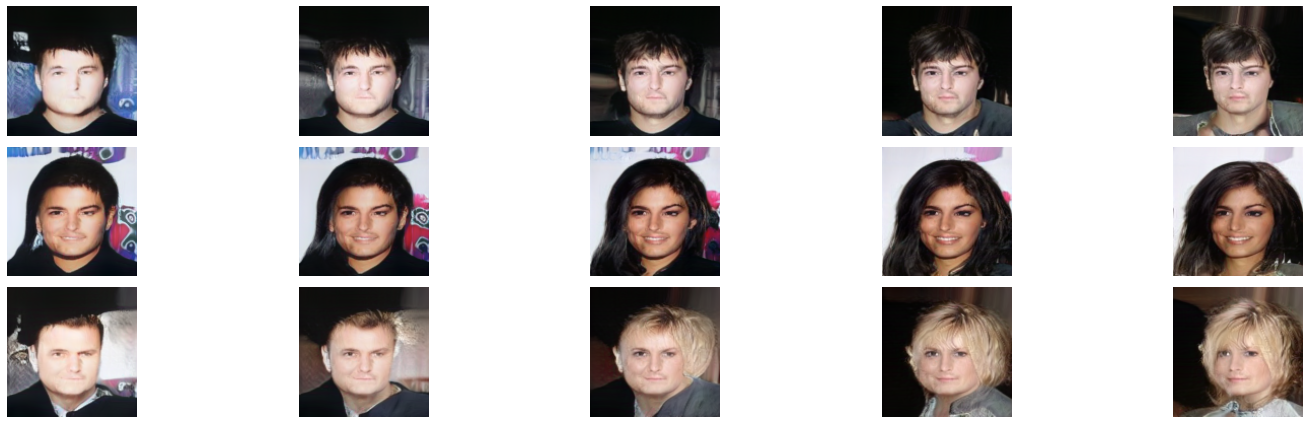

In [43]:
gen.eval()
des.eval()
f, a = plt.subplots(3,5,figsize=(22,6))
p = 10
n = 4
for face in range(3):
  for i in range(5):
    latent_c = latent.clone()
    latent_c[:,n,:,:] = latent_c[:,n,:,:] - (3*p)
    latent_c[:,n,:,:] = latent_c[:,n,:,:] + (i*p)
    result = gen(latent_c)
    result = result.cpu().detach().numpy()[face+3,:,:,:].swapaxes(0,2)
    if result.min() < 0:
      result -= result.min()
    result /= result.max()  
    a[face, i].imshow(result)
    a[face, i].set_axis_off()
plt.tight_layout()

In [12]:
gen.eval()
des.eval()
import cv2
size = (128, 128)
fps = 22

# initialize video writer
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
video_filename = 'output1.avi'
out = cv2.VideoWriter(video_filename, fourcc, fps, (size[0], size[1]))

start = latent[0,:,:,:].clone()
for face in range(1,12):
  new = latent[face,:,:,:].clone()
  for i in range(fps*3):
      combined_latent = start * (1-(i/(fps*3))) + new * (i/(fps*3))
      combined_latent = combined_latent.unsqueeze(0)
      combined_latent = combined_latent.expand(1, -1, 1, 1)
      result = gen(combined_latent)
      result = result.cpu().detach().numpy()[0,:,:,:].swapaxes(0,2)
      if result.min() < 0:
        result -= result.min()
      result /= result.max()  
      result *= 256
      result = result.astype('uint8')
      result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
      out.write(result)
  start = combined_latent[0,:,:,:]
out.release()

In [16]:
import ipywidgets as widgets
import io
import PIL
gen.eval()

def generate_image(a,b, c, d, e, f, g, g_n=6):
  latent_new = latent.clone()
  latent_new[:,0,:,:] = latent_new[:,0,:,:] + a
  latent_new[:,1,:,:] = latent_new[:,1,:,:] + b
  latent_new[:,2,:,:] = latent_new[:,2,:,:] + c
  latent_new[:,3,:,:] = latent_new[:,3,:,:] + d
  latent_new[:,4,:,:] = latent_new[:,4,:,:] + e
  latent_new[:,5,:,:] = latent_new[:,5,:,:] + f
  latent_new[:,g_n,:,:] = latent_new[:,g_n,:,:] + g
  result = gen(latent_new)
  result = result.cpu().detach().numpy()[0,:,:,:].swapaxes(0,2)
  if result.min() < 0:
    result -= result.min()
  result /= result.max()  
  return result


a = widgets.IntSlider(min=-15, max=15, step=1, orientation='vertical')
b = widgets.IntSlider(min=-15, max=15, step=1, orientation='vertical')
c = widgets.IntSlider(min=-15, max=15, step=1, orientation='vertical')
d = widgets.IntSlider(min=-15, max=15, step=1, orientation='vertical')
e = widgets.IntSlider(min=-15, max=15, step=1, orientation='vertical')
f = widgets.IntSlider(min=-15, max=15, step=1, orientation='vertical')
g = widgets.IntSlider(min=-15, max=15, step=1, orientation='vertical')
g_n = widgets.IntText(value=6,description='choose feature:',disabled=False)

box = widgets.HBox([a, b, c, d,e,f,g, g_n])
def imshow(a, b, c, d,e,f,g, g_n):
    plt.figure(figsize = (6,6))
    result = generate_image(a,b,c,d,e,f,g, g_n)
    plt.imshow(result)
    plt.axis('off')

out = widgets.interactive_output(imshow, {'a': a, 'b': b, 'c':c, 'd':d, 'e':e, 'f':f, 'g':g, 'g_n':g_n})
display(box)
display(out)

Output()

In [15]:
down = transforms.Compose([
transforms.Resize((64,64)),
 ])
V = torch.load('/content/V_celeba_200k.pth').to(device)
n_v = 512
loader = get_loader(image_paths, trans_64, 30)
for batch in loader:
  break
batch = batch.float().to(device)
real_down = down(batch)
vector_real = real_down.reshape(30,-1)
mean = vector_real.mean(1).unsqueeze(1)
vector_real = vector_real  - mean
latent = torch.matmul(vector_real, V[:, :n_v])
latent = latent[14,:].view((1,512,1,1))

latent.shape

torch.Size([1, 512, 1, 1])